# IND320 Project work - Part 2

## Links to GitHub 

GitHub repository link: https://github.com/LarsSolbakken/Ind320-Lars

Streamlit app link: https://ind320-lars-goeqtbwxguxey2shc4qfus.streamlit.app/


## Imports
Organize and load all required libraries for Spark, Cassandra, MongoDB, API requests, 
data handling, and visualization

In [2]:
# Enable inline plotting in Jupyter Notebook 
# (plots will appear directly in the notebook instead of a separate window)
%matplotlib inline  

# Standard library
import os
import subprocess

# Data handling
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Spark (big data processing) 
import pyspark
from pyspark.sql import SparkSession, Row
from pyspark.sql import functions as F

# Databases
from pymongo import MongoClient
from pymongo.server_api import ServerApi

# API requests
import requests


## 1. Setup
- Configure Java and Spark
- Initialize Spark session

In [25]:



# Check which Java version is installed (should be JDK 11 for Spark compatibility)
!java -version

print(pyspark.__version__)

# Set JAVA_HOME to JDK 11 explicitly (needed on macOS for Spark to work properly)
os.environ["JAVA_HOME"] = subprocess.check_output(
    ["/usr/libexec/java_home", "-v", "11"], text=True
).strip()
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

print("JAVA_HOME:", os.environ["JAVA_HOME"])

# Double-check Java runtime is really 11
print(subprocess.check_output(["java", "-version"], stderr=subprocess.STDOUT, text=True))

# Build Spark session and configure Cassandra + MongoDB connectors
spark = (
    SparkSession.builder
        .appName("Elhub-2021-Prod")
        # Add Spark-Cassandra connector
        .config("spark.jars.packages", "com.datastax.spark:spark-cassandra-connector_2.12:3.5.1")
        # Cassandra connection info
        .config("spark.cassandra.connection.host", "127.0.0.1")
        .config("spark.cassandra.connection.port", "9042")
        # MongoDB connection info (local dev only)
        .config("spark.mongodb.read.connection.uri",  "mongodb://127.0.0.1:27017")
        .config("spark.mongodb.write.connection.uri", "mongodb://127.0.0.1:27017")
        .getOrCreate()
)
# Suppress Spark logs
spark.sparkContext.setLogLevel("ERROR")

print(spark.sparkContext._jsc.sc().listJars())
spark


openjdk version "11.0.28" 2025-07-15
OpenJDK Runtime Environment Homebrew (build 11.0.28+0)
OpenJDK 64-Bit Server VM Homebrew (build 11.0.28+0, mixed mode)
3.5.1
JAVA_HOME: /opt/homebrew/Cellar/openjdk@11/11.0.28/libexec/openjdk.jdk/Contents/Home
openjdk version "11.0.28" 2025-07-15
OpenJDK Runtime Environment Homebrew (build 11.0.28+0)
OpenJDK 64-Bit Server VM Homebrew (build 11.0.28+0, mixed mode)

Vector(spark://10.42.83.192:52298/jars/com.datastax.spark_spark-cassandra-connector-driver_2.12-3.5.1.jar, spark://10.42.83.192:52298/jars/com.thoughtworks.paranamer_paranamer-2.8.jar, spark://10.42.83.192:52298/jars/com.typesafe_config-1.4.1.jar, spark://10.42.83.192:52298/jars/org.scala-lang.modules_scala-collection-compat_2.12-2.11.0.jar, spark://10.42.83.192:52298/jars/org.apache.commons_commons-lang3-3.10.jar, spark://10.42.83.192:52298/jars/org.hdrhistogram_HdrHistogram-2.1.12.jar, spark://10.42.83.192:52298/jars/org.apache.cassandra_java-driver-core-shaded-4.18.1.jar, spark://10.42.

## 2. Connect to MongoDB Atlas
- MongoDB connection string
- Test connection

In [24]:


try:
    # If running in Streamlit → use secrets.toml
    import streamlit as st
    uri = st.secrets["mongo"]["uri"]
except Exception:
    # If running locally → fallback to environment variable
    print("Using local environment variable for MongoDB URI")
    uri = os.getenv("MONGO_URI")

# Connect to MongoDB
client = MongoClient(uri)
try:
    client.admin.command('ping')
    print("✅ Connected to MongoDB Atlas")
except Exception as e:
    print("❌ Mongo connection failed:", e)

# Select database + collection
db = client["elhub2021"]
collection = db["production_per_group_hour"]


Using local environment variable for MongoDB URI
✅ Connected to MongoDB Atlas


## 3. Fetch Data from Elhub API
- API request loop (monthly)
- Parse JSON
- Convert to DataFrame

In [5]:


base_url = "https://api.elhub.no/energy-data/v0/price-areas"

# Generate list of all months in 2021
months = pd.date_range("2021-01-01", "2021-12-31", freq="MS")
all_data = []

for start in months:
    end = start + pd.offsets.MonthEnd(1)  # get last day of month
    
    # Define API query
    params = {
        "dataset": "PRODUCTION_PER_GROUP_MBA_HOUR",
        "startDate": start.strftime("%Y-%m-%d"),
        "endDate": end.strftime("%Y-%m-%d")
    }

    print(f"Fetching {params['startDate']} to {params['endDate']}...")

    # Request data from Elhub API
    r = requests.get(base_url, params=params)
    r.raise_for_status()
    data = r.json()
   
    # Extract "productionPerGroupMbaHour" from each item
    records = []
    for item in data["data"]:
        prod = item["attributes"].get("productionPerGroupMbaHour", [])
        records.extend(prod)

    all_data.extend(records)

# Convert API response to DataFrame
df = pd.DataFrame(all_data)
print(df.head())


Fetching 2021-01-01 to 2021-01-31...
Fetching 2021-02-01 to 2021-02-28...
Fetching 2021-03-01 to 2021-03-31...
Fetching 2021-04-01 to 2021-04-30...
Fetching 2021-05-01 to 2021-05-31...
Fetching 2021-06-01 to 2021-06-30...
Fetching 2021-07-01 to 2021-07-31...
Fetching 2021-08-01 to 2021-08-31...
Fetching 2021-09-01 to 2021-09-30...
Fetching 2021-10-01 to 2021-10-31...
Fetching 2021-11-01 to 2021-11-30...
Fetching 2021-12-01 to 2021-12-31...
                     endTime            lastUpdatedTime priceArea  \
0  2021-01-01T01:00:00+01:00  2024-12-20T10:35:40+01:00       NO1   
1  2021-01-01T02:00:00+01:00  2024-12-20T10:35:40+01:00       NO1   
2  2021-01-01T03:00:00+01:00  2024-12-20T10:35:40+01:00       NO1   
3  2021-01-01T04:00:00+01:00  2024-12-20T10:35:40+01:00       NO1   
4  2021-01-01T05:00:00+01:00  2024-12-20T10:35:40+01:00       NO1   

  productionGroup  quantityKwh                  startTime  
0           hydro    2507716.8  2021-01-01T00:00:00+01:00  
1           hydro    

## 4. Preprocess Data
- Handle time zones (UTC, summer/winter)
- Select relevant columns


In [6]:



# Convert "startTime" string → timezone-aware datetime in UTC
df["startTime"] = pd.to_datetime(df["startTime"], utc=True, errors="coerce")

# Cassandra expects UTC without timezone info → strip tz
df["startTime"] = df["startTime"].dt.tz_convert("UTC").dt.tz_localize(None)

# Keep only relevant columns
df4 = df[["priceArea", "productionGroup", "startTime", "quantityKwh"]].copy()

print(df4.head(), df4.dtypes)


  priceArea productionGroup           startTime  quantityKwh
0       NO1           hydro 2020-12-31 23:00:00    2507716.8
1       NO1           hydro 2021-01-01 00:00:00    2494728.0
2       NO1           hydro 2021-01-01 01:00:00    2486777.5
3       NO1           hydro 2021-01-01 02:00:00    2461176.0
4       NO1           hydro 2021-01-01 03:00:00    2466969.2 priceArea                  object
productionGroup            object
startTime          datetime64[ns]
quantityKwh               float64
dtype: object


## 5. Write Data to Cassandra
- Create Spark DataFrame
- Save to Cassandra keyspace and table

In [7]:



# Convert Pandas → Spark DataFrame
df_spark = spark.createDataFrame(df4)
# Lowercase column names (Cassandra convention)
df_spark = df_spark.toDF(*[c.lower() for c in df_spark.columns])

# Repartition for better Cassandra write performance
df_spark = df_spark.repartition(8, "pricearea", "productiongroup")

# Inspect schema + sample
df_spark.printSchema()
df_spark.show(5)

# Write to Cassandra
(df_spark.write
   .format("org.apache.spark.sql.cassandra")
   .options(keyspace="elhub2021", table="prod_by_group_hour")
   .mode("append")  # safe re-run, overwrites duplicates by PK
   .save()
)

print("Wrote rows to Cassandra:", df_spark.count())


root
 |-- pricearea: string (nullable = true)
 |-- productiongroup: string (nullable = true)
 |-- starttime: timestamp (nullable = true)
 |-- quantitykwh: double (nullable = true)



+---------+---------------+-------------------+-----------+
|pricearea|productiongroup|          starttime|quantitykwh|
+---------+---------------+-------------------+-----------+
|      NO1|          other|2020-12-31 23:00:00|        0.0|
|      NO1|          other|2021-01-01 00:00:00|        0.0|
|      NO1|          other|2021-01-01 01:00:00|        0.0|
|      NO1|          other|2021-01-01 02:00:00|        0.0|
|      NO1|          other|2021-01-01 03:00:00|        0.0|
+---------+---------------+-------------------+-----------+
only showing top 5 rows



Wrote rows to Cassandra: 208248


## 6. Read Data from Cassandra
- Load back into Spark
- Convert to Pandas

In [8]:
# Read the Cassandra table "prod_by_group_hour" in the "elhub2021" keyspace
df_cassandra = (spark.read
    .format("org.apache.spark.sql.cassandra")       # Use the Cassandra Spark connector
    .options(keyspace="elhub2021", table="prod_by_group_hour")
    .load())

# Print the schema to confirm data types of each column
df_cassandra.printSchema()

# Show the first 5 rows of the DataFrame
df_cassandra.show(5)


root
 |-- pricearea: string (nullable = false)
 |-- productiongroup: string (nullable = false)
 |-- starttime: timestamp (nullable = true)
 |-- quantitykwh: double (nullable = true)

+---------+---------------+-------------------+-----------+
|pricearea|productiongroup|          starttime|quantitykwh|
+---------+---------------+-------------------+-----------+
|      NO1|          hydro|2020-12-31 23:00:00|  2507716.8|
|      NO1|          hydro|2021-01-01 00:00:00|  2494728.0|
|      NO1|          hydro|2021-01-01 01:00:00|  2486777.5|
|      NO1|          hydro|2021-01-01 02:00:00|  2461176.0|
|      NO1|          hydro|2021-01-01 03:00:00|  2466969.2|
+---------+---------------+-------------------+-----------+
only showing top 5 rows



## 7. Insert Data into MongoDB
- Use PyMongo to insert cleaned data
- Verify insertion

In [9]:

df_pd = df_cassandra.toPandas()
records = df_pd.to_dict(orient="records")

# Insert into MongoDB Atlas
db = client["elhub2021"]
collection = db["production_per_group_hour"]
collection.delete_many({})        # clear old data
collection.insert_many(records)   # insert fresh data

print(f"✅ Inserted {len(records)} rows from Cassandra into MongoDB")


✅ Inserted 208224 rows from Cassandra into MongoDB


## 8. Visualization in Jupyter
- Pie chart for total production
- Line plot for January production

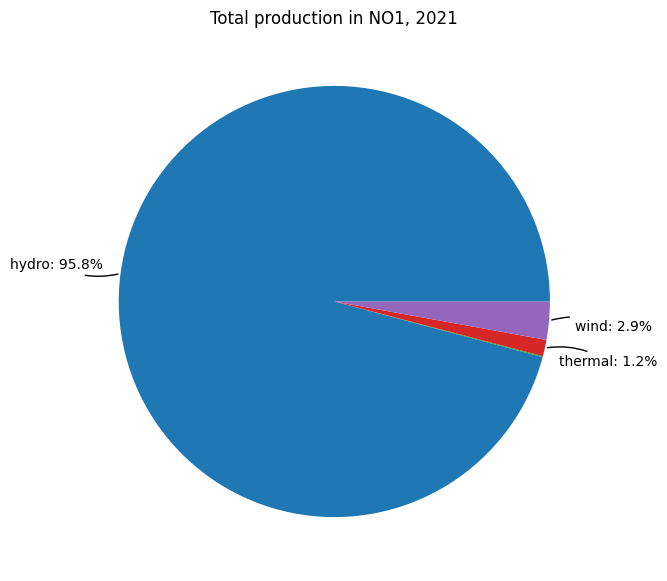

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Filter one price area (example: NO1)
area = "NO1"
df_area = df_pd[df_pd["pricearea"] == area]

# Group by production group and sum
totals = df_area.groupby("productiongroup")["quantitykwh"].sum()

plt.figure(figsize=(7,7))

# Plot the pie without labels (only wedges)
wedges, texts = plt.pie(
    totals
      # keep consistent orientation
)

plt.title(f"Total production in {area}, 2021")
plt.ylabel("")

# Add annotations with arrows, but skip tiny slices (<1%)
for i, wedge in enumerate(wedges):
    pct = totals.iloc[i] / totals.sum() * 100
    if pct < 1:   # skip if slice is <1%
        continue

    ang = (wedge.theta2 - wedge.theta1)/2. + wedge.theta1  # angle of slice
    x = np.cos(np.deg2rad(ang))
    y = np.sin(np.deg2rad(ang))

    # Label text (name + %)
    label = f"{totals.index[i]}: {pct:.1f}%"

    # Place label outside the pie
    plt.annotate(
        label,
        xy=(x, y), xytext=(1.3*x, 1.3*y),
        arrowprops=dict(arrowstyle="-", connectionstyle="arc3,rad=0.2"),
        ha="center", va="center"
    )



plt.show()



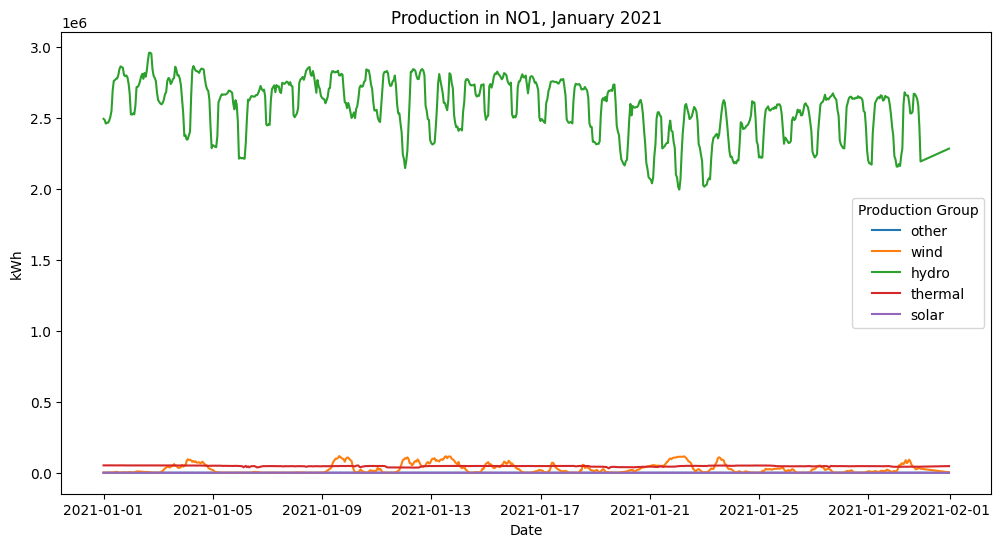

In [11]:
# Filter only January data
df_area_jan = df_area[
    (df_area["starttime"] >= "2021-01-01") &
    (df_area["starttime"] < "2021-02-01")
]

# Plot line chart for each production group
plt.figure(figsize=(12,6))
sns.lineplot(data=df_area_jan, x="starttime", y="quantitykwh", hue="productiongroup")
plt.title(f"Production in {area}, January 2021")
plt.xlabel("Date")
plt.ylabel("kWh")
plt.legend(title="Production Group")
plt.show()


# Normalized Production Trends
The plot below shows normalized production (each group scaled to 0–1). While hydro dominates in absolute terms, normalization highlights the relative variation of smaller sources.
Solar shows daily cycles.
Wind fluctuates strongly.
Hydro appears stable in comparison.
This plot does not show actual production levels, but instead helps compare patterns across groups of very different scales.

Text(0, 0.5, 'Normalized kWh (0-1)')

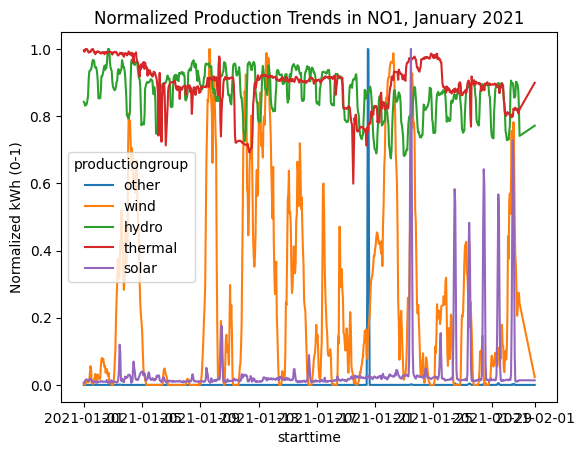

In [12]:

# Create copy and normalize values (divide by max within each group)
df_area_jan_norm = df_area_jan.copy()
df_area_jan_norm["quantitykwh_norm"] = (
    df_area_jan_norm.groupby("productiongroup")["quantitykwh"].transform(lambda x: x / x.max())
)

# Plot normalized data (all groups scaled to 0-1)
sns.lineplot(
    data=df_area_jan_norm,
    x="starttime", y="quantitykwh_norm", hue="productiongroup"
)
plt.title("Normalized Production Trends in NO1, January 2021")
plt.ylabel("Normalized kWh (0-1)")


# AI Usage  

In this project, I made active use of **AI tools (ChatGPT)** as a coding assistant.  
The main purpose was to **troubleshoot technical issues** and speed up my learning when working with **Spark, Cassandra, and MongoDB**.  

I initially struggled with connecting Spark to Cassandra and MongoDB, and especially with reading and writing data between the two systems. AI helped me understand:  
- Configuration errors  
- Environment variables such as `JAVA_HOME`  
- Connector version mismatches  

AI also assisted in explaining concepts such as:  
- **Time zone handling** (summer/winter time)  
- The structure of the **Elhub API**  
- How to prepare **Streamlit widgets** (`st.radio`, `st.pills`, etc.) for visualization  

Overall, AI functioned as a **tutor and debugging partner**.  
All final code was **run, tested, and commented by me** to ensure I fully understood how it worked.  


# Log  

This part of the project was more challenging than the first because it involved multiple technologies: **Spark, Cassandra, MongoDB, and Streamlit**, in addition to working with the **Elhub API**.  

I started by setting up Spark with Cassandra. One of the first difficulties I ran into was related to **Java**. Even though I had installed the correct version (JDK 11), my system still tried to use the wrong Java version by default. This caused repeated errors until I explicitly set the `JAVA_HOME` environment variable and adjusted my `PATH` to point to JDK 11. Once this was solved, I could finally connect Spark and write Elhub data to Cassandra.  

The biggest challenge came with **MongoDB**. I initially tried to use Spark to write directly into MongoDB, but I ran into repeated connector errors that I could not resolve. After spending a lot of time troubleshooting, I switched strategy and used **PyMongo** instead. This allowed me to connect to MongoDB Atlas and insert the data after preparing it with Spark and Pandas. This solution was simpler and more reliable, even if it bypassed Spark’s MongoDB connector.  

Once the data was in MongoDB, I focused on **visualization**. In the Jupyter Notebook, I created a **pie chart** for total production and a **line plot** for the first month of the year. These were then adapted to the Streamlit app.  

In Streamlit, I created a page that split into two columns:  
- On the **left**, the user can select a price area with radio buttons to see a pie chart of production groups.  
- On the **right**, the user can choose production groups with pills and a month with a selector to generate a line plot.  

Finally, I added an expander with a short explanation of the data source.  

During development, I often relied on **AI (ChatGPT)** to debug errors, explain time zone conversions, and suggest improvements to the Streamlit interface. At the same time, I made sure to understand and re-run all code myself.  

Looking back, I learned a lot about working with databases and data visualization. Even though I faced problems with MongoDB at the start, and with Spark/Java configuration earlier, I now have a working pipeline:  

**Elhub API → Spark → Cassandra → MongoDB → Streamlit**  

This feels like a real achievement.  
